## Classifying with transfer learning


In [19]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import torch.nn as nn

In [25]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.datasets import DatasetFolder

from torchvision import transforms
from torchvision import models
from tempfile import TemporaryDirectory


Transormations


In [3]:
data_transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_transform_val = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
root = "data\hymenoptera_data\hymenoptera_data"
train_dir = os.path.join(root, 'train')
val_dir = os.path.join(root, 'val')

train_dataset = ImageFolder(root=train_dir, transform=data_transform_train)
val_dataset = ImageFolder(root=val_dir, transform=data_transform_val)


In [5]:
train_dataset.classes, train_dataset.class_to_idx

(['ants', 'bees'], {'ants': 0, 'bees': 1})

In [11]:
class_names = train_dataset.classes


In [6]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

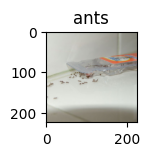

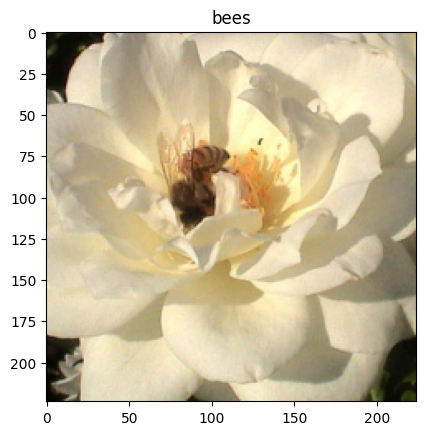

In [7]:
img, clsIdx = train_dataset[0]

figure = plt.figure(figsize=(4,4))

for i in range(2):
    randIdx = torch.randint(len(train_dataset), size=(1,)).item()
    subplot = figure.add_subplot(3, 1, i+1)
    img, clsIdx = train_dataset[randIdx]
    imshow(img, train_dataset.classes[clsIdx])



Data loaders

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

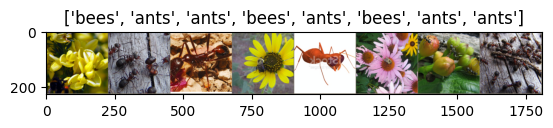

In [9]:
## make a grid from batch

import torchvision


bat1_inputs, bat1_vals = next(iter(train_dataloader))


grid = torchvision.utils.make_grid(bat1_inputs)

imshow(grid, title=[train_dataset.classes[i] for i in bat1_vals])


## Training the model

In [28]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25, device='cpu'):
    st_time = time.time()


    with TemporaryDirectory() as temp_dir:
        best_model_params_path = os.path.join(temp_dir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f"Epoch {epoch}/{num_epochs}")
            print("-"*10)

            ### Train
            model.train()
            running_loss = 0.0
            running_corrects = 0.0

            ## Train loop

            for inputs, labels in train_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                ### zero grad

                optimizer.zero_grad()

                ## Forward

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                ## backward pass
                loss.backward()

                ## update weights
                optimizer.step()

                ## Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                scheduler.step()
                
            epoch_loss = running_loss / len(train_dataset)
            epoch_acc = running_corrects.double() / len(train_dataset)
            print(f"Train loss :  Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ")



            ## Validation loop
            model.eval()
            for inputs, labels in test_dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                
                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                

            epoch_loss = running_loss / len(train_dataset)
            epoch_acc = running_corrects.double() / len(train_dataset)

            print(f"Val loss :  Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ")
            # deep copy the model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)



        ### end of training
        time_elapsed = time.time() - st_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        ## load model best weights
        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path, weights_only=True))

    return model

    

In [65]:
random_index = torch.randint(0, len(val_dataset), size=(6,))
random_indices_list = list(random_index.numpy())
random_indices_list



[127, 15, 111, 40, 14, 21]

### Generic function for displaying predictions

In [72]:
if torch.cuda.is_available():
    device ='cuda'
else:
    device = 'cpu'

def visualize_predictions(model, num_images = 6):
    was_training = model.training
    model.eval()

    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        # random_index = torch.randint(0, len(test_dataloader), size=(1,)).item()
        random_index = torch.randint(0, len(val_dataset), size=(6,))
        random_indices_list = list(random_index.numpy())
        for random_index in random_indices_list:
            inputs, labels = val_dataset[random_index]
            inputs = inputs.to(device)
            # labels = labels.to(device)
            inputs = inputs.unsqueeze(0)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(preds)
        
            for j in range(inputs.size()[0]):
                images_so_far +=1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f"predicted : {class_names[preds]}")
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return



# FineTuning Model ConvNet

In [15]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')

In [18]:
num_in_features = model_ft.fc.in_features
num_in_features

512

In [20]:
## Set output to 2 because of 2 labels

model_ft.fc = nn.Linear(num_in_features, 2)

In [21]:
model_ft.fc

Linear(in_features=512, out_features=2, bias=True)

In [22]:
model_ft = model_ft.to(device)

In [23]:
criterion= nn.CrossEntropyLoss()

## Ensure that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)



In [24]:
# decay LR by factor of 0.1 every 7 steps

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma = 0.1)



In [29]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25, device='cuda')

Epoch 0/25
----------
Train loss :  Loss: 0.4302 Acc: 0.7951 
Val loss :  Loss: 0.5600 Acc: 1.3648 
Epoch 1/25
----------
Train loss :  Loss: 0.2287 Acc: 0.8975 
Val loss :  Loss: 0.3519 Acc: 1.4836 
Epoch 2/25
----------
Train loss :  Loss: 0.1797 Acc: 0.9303 
Val loss :  Loss: 0.3070 Acc: 1.5164 
Epoch 3/25
----------
Train loss :  Loss: 0.1417 Acc: 0.9467 
Val loss :  Loss: 0.2648 Acc: 1.5451 
Epoch 4/25
----------
Train loss :  Loss: 0.1341 Acc: 0.9426 
Val loss :  Loss: 0.3380 Acc: 1.5082 
Epoch 5/25
----------
Train loss :  Loss: 0.1280 Acc: 0.9549 
Val loss :  Loss: 0.2754 Acc: 1.5287 
Epoch 6/25
----------
Train loss :  Loss: 0.1216 Acc: 0.9549 
Val loss :  Loss: 0.2657 Acc: 1.5287 
Epoch 7/25
----------
Train loss :  Loss: 0.0696 Acc: 0.9672 
Val loss :  Loss: 0.2491 Acc: 1.5369 
Epoch 8/25
----------
Train loss :  Loss: 0.0691 Acc: 0.9713 
Val loss :  Loss: 0.2022 Acc: 1.5615 
Epoch 9/25
----------
Train loss :  Loss: 0.1163 Acc: 0.9467 
Val loss :  Loss: 0.2571 Acc: 1.5246 


c:\Users\Nilesh\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tensor([0], device='cuda:0')


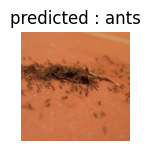

tensor([0], device='cuda:0')


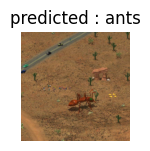

tensor([0], device='cuda:0')


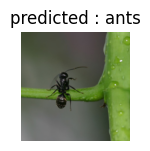

tensor([0], device='cuda:0')


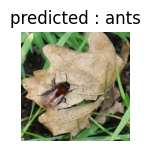

tensor([0], device='cuda:0')


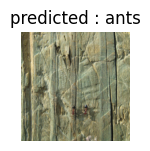

tensor([1], device='cuda:0')


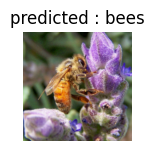

In [75]:
visualize_predictions(model_ft)

## Freeze all layers except last layer

In [93]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')


for param in model_conv.parameters():
    param.requires_grad = False
    

In [94]:
n_input_features = model_conv.fc.in_features

In [95]:
model_conv.fc = nn.Linear(n_input_features, 2)

In [96]:
next(model_conv.fc.parameters())

Parameter containing:
tensor([[-0.0294,  0.0019,  0.0343,  ...,  0.0357, -0.0251,  0.0428],
        [ 0.0388,  0.0405, -0.0332,  ...,  0.0280, -0.0377,  0.0005]],
       requires_grad=True)

In [100]:
model_conv = model_conv.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = torch.optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [101]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/25
----------


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor